__Étudiante__ : Madina TRAORÉ

#### Imports

In [1]:
import random
import numpy as np
from ipynb.fs.defs.toolbox import softmax
from ipynb.fs.defs.mdp import maze_mdp # Markov Decision Process # RETIRER LES OCCURENCES DE "%notebook" DE mdp.py
                                       # POUR QUE CET IMPORT PUISSE SE FAIRE
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

In [2]:
import numpy as np
import random
from ipynb.fs.defs.toolbox import N, S, E, W, discreteProb
from ipynb.fs.defs.maze_plotter import maze_plotter # used to plot the maze

    
class simple_actspace(): #class describing the action space of the markov decision process
    def __init__(self, action_list=[], nactions=0):
        if len(action_list) == 0:
            self.actions = np.array([a for a in range(nactions)])
        else:
            self.actions = action_list
            
        self.size = len(self.actions)
        
    def sample(self, prob_list=None): #returns an action drawn according to the prob_list distribution, 
        # if the param is not set, then it is drawn from a uniform distribution 
        if prob_list is None :
            prob_list = np.ones((self.size))/self.size
            
        index = discreteProb(prob_list) 
        return  self.actions[index]
    

        
    
class mdp(): #defines a Markov Decision Process

    def __init__(self, observation_space, action_space, start_distribution, transition_matrix,
                  reward_matrix, plotter, gamma=0.9, terminal_states=[], timeout=50):
        
        self.observation_space = observation_space
        self.terminal_states = terminal_states
        self.action_space = action_space
        self.current_state = -1 #current position of the agent in the maze, it's set by the method reset()
        self.timeout = timeout #maximum length of an episode
        self.timestep = 0 
        self.P0 = start_distribution #distribution used to draw the first state of the agent, used in method reset()
        self.P = transition_matrix
        self.r = reward_matrix
        self.plotter = plotter #used to plot the maze
        self.gamma = gamma #discount factor
        self.last_action_achieved = False #used to tell whether the last state has been reached or not (see done())
    
    

    def reset(self, uniform=False): #initializes an episode and returns the state of the agent
        #if uniform is set to False, the first state is drawn according to the P0 distribution, 
        #else it's drawn on a uniform distribution over all the states
        
        if uniform :
            prob = np.ones((self.observation_space.size))/self.observation_space.size
            self.current_state = discreteProb(prob)
        else :
            self.current_state = discreteProb(self.P0)
            
        self.timestep = 0
        self.last_action_achieved = False
        
        return self.current_state
 
    
    def step(self,u,deviation=0): # performs a step forward in the environment, 
        # if you want to add some noise to the reward, give a value to the deviation param 
        # which represents the mean μ of the normal distribution used to draw the noise 
        
        noise = 0 #= deviation*np.random.randn() # generate noise, see an exercize in mbrl.ipynb
        reward = self.r[self.current_state,u] +noise # r is the reward of the transition, you can add some noise to it 
        
        # the state reached when performing action u from state x is sampled 
        # according to the discrete distribution self.P[x,u,:]
        observation = discreteProb(self.P[self.current_state,u,:]) 
        
        self.timestep += 1 
        
        
        info = {} #can be used when debugging
        info["State transition probabilities"] = self.P[self.current_state,u,:]
        info["reward's noise value"] = noise
        
        self.current_state = observation
        done = self.done() #checks if the episode is over
        
        return [observation,reward,done,info]
    
    
    def done(self): #returns True if the episode is over
        if self.last_action_achieved :
            return True
        if self.current_state in self.terminal_states: #done when a terminal state is reached
            #the terminal states are actually a set of states from which any action leads to an added imaginary state, 
            #the "well", with a reward of 1. To know if the episode is over, we have to check
            #whether the agent is on one of these last states and performed the action that gives it its last reward 
            self.last_action_achieved = True
            
        return self.timestep == self.timeout #done when timeout reached
    
    
    def new_render(self): #initializes a new environment rendering (a plot defined by a figure, an axis...)
        self.plotter.new_render()
    
    def render(self, V=[], policy=[], agent_pos=-1): #outputs the agent in the environment with values V (or Q)
        
        if agent_pos > -1:
            self.plotter.render(agent_state=agent_pos, V=V, policy=policy)
        elif self.current_state > -1:# and not self.last_action_achieved:
            self.plotter.render(agent_state=self.current_state, V=V, policy=policy)
        else :
            self.plotter.render(V=V, policy=policy)
        
    def save_fig(self, title): #saves the current output into the disk
        self.plotter.save_fig(title)
            
    def create_animation(self,V_list=[],policy_list=[],nframes=0): #given a list of V or Q values, a list of policies, 
        # and eventually the number of frames wanted, it generates a video of the different steps
        return self.plotter.create_animation(V_list,policy_list,nframes)
    

class maze(): #describes a maze-like environment
    def __init__(self, width, height, walls=[]):
        self.width = width
        self.height = height
        self.states = np.array([s for s in range(width*height)])
        self.walls = walls
        self.size = width*height
     

    
class maze_mdp(mdp): #defines a Markov Decision Process which observation space is a maze

    def __init__(self, width, height, walls=[], action_list=[], nactions=4,
                 gamma=0.9, timeout=50, start_states=[0], terminal_states=[]):
        #width, height : int numbers defining the maze attributes
        #walls : list of the states that represent walls in our maze environment
        #action_list : list of possible actions
        #nactions : used when action_list is empty, by default there are 4 of them (go north, south, eat or west)
        #gamma : the discount factor of our mdp
        #timeout : defines the length of an episode (max timestep) --see done() function
        #start_states : list that defines the states where the agent can be at the beginning of an episode
        #terminal_states : list that defines the states corresponding to the end of an episode
        #                  (agent reaches a terminal state) --cf. done() function
        
        ###################### State Space ######################
        
        observation_space = maze(width, height, walls)
        
        ###################### Action Space ######################
        
        action_space = simple_actspace(action_list=action_list, nactions=nactions)    
        
        
        ###################### Distribution Over Initial States ######################
        
        start_distribution = np.zeros((observation_space.size)) #distribution over initial states
        
        for state in start_states:
            start_distribution[state] = 1.0/len(start_states)

        ###################### Transition Matrix ######################
        
        transition_matrix = np.empty((observation_space.size+1,action_space.size,observation_space.size+1)) #a "well" state is added that only the terminal states can get into
        
        # Transition Matrix when going north
        transition_matrix[:,N,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i == 0 or i%observation_space.height == 0 or i-1 in observation_space.walls or i in observation_space.walls: #the state doesn't change (highest cells + cells under a wall)
                transition_matrix[:,N,:][i][i] = 1.0
            else : #it goes up
                transition_matrix[:,N,:][i][i-1] = 1.0
        
        # Transition Matrix when going south
        transition_matrix[:,S,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i%observation_space.height == observation_space.height-1 or i+1 in observation_space.walls or i in observation_space.walls: #the state doesn't change (lowest cells + cells above a wall)
                transition_matrix[:,S,:][i][i] = 1.0
            else : #it goes down
                transition_matrix[:,S,:][i][i+1] = 1.0
    
        #self.P[:,S,:][49][50] = 0.2 #example for hacking local probabilities
        #self.P[:,S,:][49][48] = 0.8


        # Transition Matrix when going west
        transition_matrix[:,W,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i<observation_space.height or i-observation_space.height in observation_space.walls or i in observation_space.walls: #state doesn't change (cells on the right side of a wall)
                transition_matrix[:,W,:][i][i] = 1.0
            else : #it goes left
                transition_matrix[:,W,:][i][i-height] = 1.0
        

        # Transition Matrix when going east
        transition_matrix[:,E,:] = np.zeros((observation_space.size+1,observation_space.size+1))
        for i in observation_space.states : 
            if i>observation_space.size-observation_space.height-1 or i+observation_space.height in observation_space.walls or i in observation_space.walls: #state doesn't change (cells on the left side of a wall)
                transition_matrix[:,E,:][i][i] = 1.0
            else : #it goes right
                transition_matrix[:,E,:][i][i+height] = 1.0
                
        # Transition Matrix of final states 
        well = observation_space.size # all the final states' transitions go there
        for s in terminal_states:
            transition_matrix[s,:,:] = 0
            transition_matrix[s,:,well] = 1
            
        
        # Transition Matrix when not moving (action removed from the current version)
        #transition_matrix[:,NoOp,:] = np.eye(observation_space.size)

        ###################### Reward Matrix ######################

        reward_matrix = np.zeros((observation_space.size, action_space.size)) 
        for s in terminal_states:
            reward_matrix[s,:] = 1 # leaving a final state gets the agent a reward of 1
        #reward_matrix[-1][NoOp] = 1.0
        #reward_matrix[25][NoOp] = 0.9
        
        plotter = maze_plotter(observation_space, terminal_states) #renders the environment
        mdp.__init__(self, observation_space, action_space, start_distribution, transition_matrix,
                 reward_matrix, plotter, gamma=gamma, terminal_states=terminal_states, timeout=timeout)

    
    def reset(self, uniform=False): #initializes an episode
        #if uniform is set to False, the first state is drawn from the P0 distribution, 
        #else it is drawn from a uniform distribution over all the states except for walls
        if uniform:
            prob = np.ones((self.observation_space.size))/(self.observation_space.size-len(self.observation_space.walls))
            for state in self.observation_space.walls:
                prob[state]= 0.0 
            self.current_state = discreteProb(prob)
        else :
            self.current_state = discreteProb(self.P0)

        self.timestep = 0
        self.last_action_achieved = False
        return self.current_state
    
    def uniformSampling(self):
        
        action = random.choice(self.action_space.actions)
        prob = np.ones((self.observation_space.size))/(self.observation_space.size-len(self.observation_space.walls))
        for state in self.observation_space.walls:
            prob[state]= 0.0 
        state = discreteProb(prob)
        reward = self.r[state,action] # r is the reward of the transition, you can add some noise to it 
        observation = discreteProb(self.P[state,action,:]) 
        sample = Sample(state, action, reward, observation)
        return sample

# Understanding on-policy and off-policy properties 

In this part, we investigate the difference between the off-policy property of Q-learning and the on-policy property of SARSA. For doing so, we will feed the critic of these algorithms with off-policy data stored into a replay buffer.
Using a replay buffer is not mandatory when using random uniform samples, but using this approach makes the architecture more flexible for later experiments.

### Create a class Sample

A sample contains the following information : the current state, the current action, the resulting reward, and the resulting next state.

In the cell below, create a class to store a sample

In [3]:
class Sample():

    def __init__(self, x, a, r, next_x):
        
        self.x = x
        self.a = a
        self.r = r
        self.next_x = next_x

### Create a class ReplayBuffer

A replay buffer is a FIFO list of samples with a limited size (often set to 10^6). 

In the cell below, create a class ReplayBuffer. Give it a method __add(sample)__ to add a sample, a method __draw()__ to draw a sample randomly

In [4]:
class ReplayBuffer():

    def __init__(self, size):
        self.size = size
        self.samples = []
    
    def add(self, sample):
        if len(self.samples) < self.size:
            self.samples.append(sample)
    
    def draw(self):
        return random.choice(self.samples)

In your mdp class, add a method __uniformSampling()__ which returns a randomly generated sample: it draws a state and an action at random, provides the corresponding reward and next state, stores these into a sample and returns that sample.

In the box below, get your Q-learning code from [reinforcement_learning.ipynb](reinforcement_learning.ipynb), and copy-paste it.

In [5]:
def QLearning_with_replay_buffer(mdp,tau,replay_buffer,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
        
    for i in range(nEpisodes) :
        done = False
        while not done:
            sample = replay_buffer.draw()
            x = sample.x
            mdp.current_state = x
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using a soft-max policy
            u = sample.a
            y = sample.next_x
            r = sample.r

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                Qmax = Q.max(axis=1)
                delta = r + mdp.gamma*Qmax[y] - Q[x,u]
                Q[x,u] += alpha*delta
            
            done = mdp.done()
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

Modify the above code so that, instead of being fed by the samples of an agent running its current policy, the Q-table is fed by samples drawn randomly from the replay buffer.


### Writing the main code
 
 Below, write a code that:
 * creates a replay buffer containing 10.000 samples drawn uniformly from the mdp,
 * makes Q-learning learn from samples drawn uniformly from the replay buffer for a fixed number of episodes,
 * visualizes the results.


In [6]:
walls = [5,6]
height = 3
width = 3
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1])

In [7]:
replay_buffer = ReplayBuffer(10000)
for i in range(replay_buffer.size):
    sample = m.uniformSampling()
    replay_buffer.add(sample)

<IPython.core.display.Javascript object>


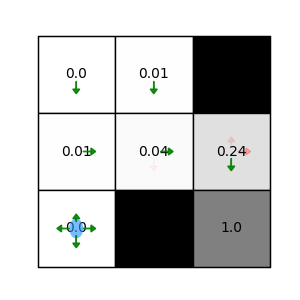

In [8]:
%matplotlib notebook

Q_list, policy_list = QLearning_with_replay_buffer(m,0.1,replay_buffer,nEpisodes=100,nTimesteps=50,alpha=0.1)

<IPython.core.display.Javascript object>


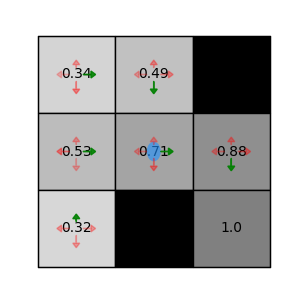

In [15]:
%matplotlib notebook

Q_list, policy_list = QLearning_with_replay_buffer(m,0.1,replay_buffer,nEpisodes=1000,nTimesteps=50,alpha=0.1)

What do you observe? Is this algorithm converging to an optimal Q-table?

Now, do the same with SARSA: import it below, and modify it as you did for Q-learning (or just change your modified Q-learning into a modified SARSA below, this is easier).


In [9]:
def SARSA_with_replay_buffer(mdp,tau,replay_buffer,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
        
    for i in range(nEpisodes) :
        done = False
        while not done:
            sample = replay_buffer.draw()
            x = sample.x
            mdp.current_state = x
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using a soft-max policy
            u = sample.a

            y = sample.next_x
            
            r = sample.r

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                next_u = mdp.action_space.sample(prob_list=softmax(Q,y,tau))
                delta = r + mdp.gamma*Q[y,next_u] - Q[x,u]
                Q[x,u] += alpha*delta
            
            done = mdp.done()
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

In [10]:
walls = [5,6]
height = 3
width = 3
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=[height*width-1])

In [11]:
replay_buffer = ReplayBuffer(10000)
for i in range(replay_buffer.size):
    sample = m.uniformSampling()
    replay_buffer.add(sample)

<IPython.core.display.Javascript object>


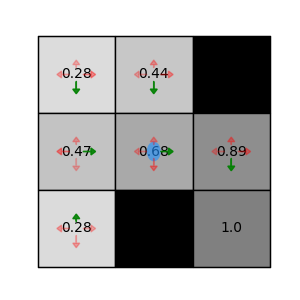

In [12]:
%matplotlib notebook

QPI_list, polS_list = SARSA_with_replay_buffer(m,0.1,replay_buffer,nEpisodes=1000,nTimesteps=50,alpha=0.1)

Again, what do you observe? Is this algorithm converging to an optimal Q-table?
Discuss the difference.
To go further and better understand the convergence properties of SARSA, read [the paper where its convergence was proven](https://link.springer.com/content/pdf/10.1023/A:1007678930559.pdf)